In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error

plt.rcParams['figure.figsize'] = (12,6)

# Step 1 - Load and prepare the data

In [2]:
df = pd.read_csv('/Users/braulio/Documents/data/ECA_blended_custom/temp_data.txt')
df.head()

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52777 entries, 0 to 52776
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SOUID     52777 non-null  int64
 1       DATE  52777 non-null  int64
 2      TG     52777 non-null  int64
 3    Q_TG     52777 non-null  int64
dtypes: int64(4)
memory usage: 1.6 MB


## Temperature Forecast I
Discuss the following questions:

1. What does the temperature forecast for Berlin for any given day depend on? The year? Is there an underlying trend the temperature follows? The day of the year? Does the temperature depend on the season of the year? The temperature of the previous day? Is the present able to explain part of the (near) future?
2. If we know the day of the year, the year and the temperature of the previous day, are we able to perfectly predict the temperature of any given day in Berlin?

## Temperature Forecast II
Which information is most useful for predicting tomorrows temperature in Berlin?

The temperature in Berlin one year ago?

The long term average temperature in Berlin of tomorrows date?

Todays temperature in Berlin?

### Plot the time series

In [4]:
df.columns

Index(['SOUID', '    DATE', '   TG', ' Q_TG'], dtype='object')

In [5]:
# pd.to_datetime(df['DATE'])
df.columns = ['Source_ID', 'DATE', 'temp', 'q_tg']

In [6]:
df["datetime"] = pd.to_datetime(df["DATE"], format='%Y%m%d')

In [7]:
df.head()

,Source_ID,DATE,temp,q_tg,datetime
0,127488,18760101,22,0,1876-01-01
1,127488,18760102,25,0,1876-01-02
2,127488,18760103,3,0,1876-01-03
3,127488,18760104,-58,0,1876-01-04
4,127488,18760105,-98,0,1876-01-05


In [8]:
df['day'] = df['datetime'].dt.day

df['month'] = df['datetime'].dt.month

df['year'] = df['datetime'].dt.year

In [9]:
df.drop('DATE', axis=1, inplace=True)
df.set_index('datetime', inplace=True)

df.head()

,Source_ID,temp,q_tg,day,month,year
datetime,,,,,,
1876-01-01,127488,22,0,1,1,1876
1876-01-02,127488,25,0,2,1,1876
1876-01-03,127488,3,0,3,1,1876
1876-01-04,127488,-58,0,4,1,1876
1876-01-05,127488,-98,0,5,1,1876


In [10]:
## CONVERT MEAN_TEMP TO KELVIN TO AVOID FUTURE 0 DIVISIONS
df.loc[:,'temp'] *= 0.1
df.loc[:,'temp'] += 273.15

df.head()

,Source_ID,temp,q_tg,day,month,year
datetime,,,,,,
1876-01-01,127488,275.35,0,1,1,1876
1876-01-02,127488,275.65,0,2,1,1876
1876-01-03,127488,273.45,0,3,1,1876
1876-01-04,127488,267.35,0,4,1,1876
1876-01-05,127488,263.35,0,5,1,1876


### Check for missing values
#### Quality code for TG (0='valid'; 1='suspect'; 9='missing')

In [11]:
df[df['q_tg'] == 9]

,Source_ID,temp,q_tg,day,month,year
datetime,,,,,,
1945-04-25,127488,-726.75,9,25,4,1945
1945-04-26,127488,-726.75,9,26,4,1945
1945-04-27,127488,-726.75,9,27,4,1945
1945-04-28,127488,-726.75,9,28,4,1945
1945-04-29,127488,-726.75,9,29,4,1945
...,...,...,...,...,...,...
1945-11-01,127488,-726.75,9,1,11,1945
1945-11-02,127488,-726.75,9,2,11,1945
1945-11-03,127488,-726.75,9,3,11,1945


In [12]:
# values for the same dates with missing values, but from preivous year:
# prev_temps = df['1944-04-25':'1944-11-05']['temp'].values

In [13]:
# values from following year for the same dates with missing values:
# df['1946-04-25':'1946-11-05']['temp'].values

In [14]:
# average between previous year and following year temperature, for the dates with missing values in 1945:
new_val = (df['1946-04-25':'1946-11-05']['temp'].values + df['1944-04-25':'1944-11-05']['temp'].values)*0.5

In [15]:
new_idx = df['1945-04-25':'1945-11-05'].index

In [16]:
s_1945_new = pd.Series(new_val, index = new_idx)
s_1945_new

datetime
1945-04-25    284.65
1945-04-26    286.55
1945-04-27    285.45
1945-04-28    284.30
1945-04-29    283.25
               ...  
1945-11-01    278.55
1945-11-02    278.75
1945-11-03    279.40
1945-11-04    280.25
1945-11-05    280.90
Length: 195, dtype: float64

In [17]:
df.loc['1945-04-25':'1945-11-05', 'temp'] = s_1945_new

In [18]:
df[df['q_tg'] == 9]

,Source_ID,temp,q_tg,day,month,year
datetime,,,,,,
1945-04-25,127488,284.65,9,25,4,1945
1945-04-26,127488,286.55,9,26,4,1945
1945-04-27,127488,285.45,9,27,4,1945
1945-04-28,127488,284.30,9,28,4,1945
1945-04-29,127488,283.25,9,29,4,1945
...,...,...,...,...,...,...
1945-11-01,127488,278.55,9,1,11,1945
1945-11-02,127488,278.75,9,2,11,1945
1945-11-03,127488,279.40,9,3,11,1945


Drop irrelevant column

In [19]:
df['Source_ID'].unique()

array([127488, 111448, 127848, 121152])

In [20]:
df.drop('Source_ID', axis=1, inplace=True)

Dataframe is now ready for plotting!

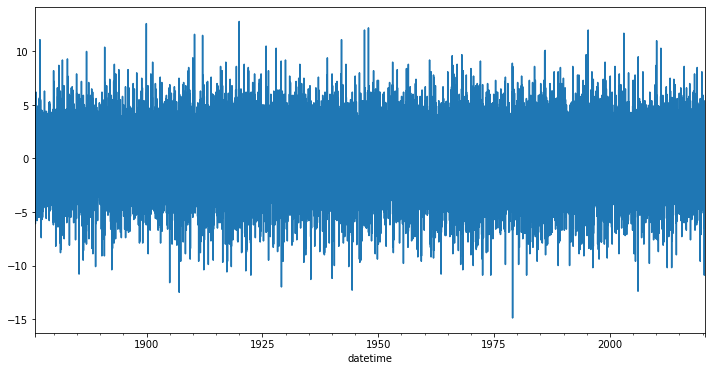

In [21]:
# Plot the series
df['temp'].diff().plot()

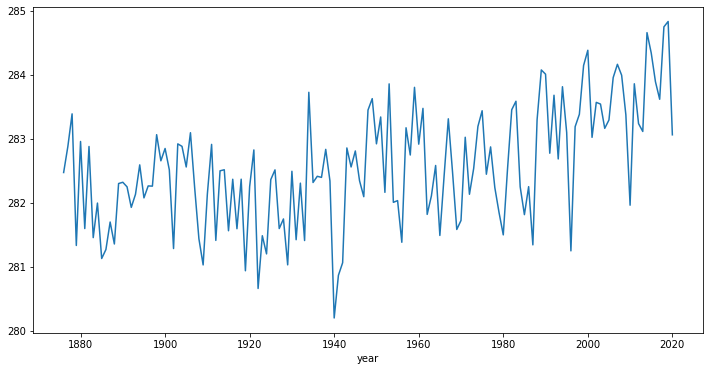

In [22]:
df.groupby('year')['temp'].mean().plot()

# Step 2 - Split the time series into training and test set

In [23]:
df.tail()

,temp,q_tg,day,month,year
datetime,,,,,
2020-06-26,296.05,0,26,6,2020
2020-06-27,297.95,0,27,6,2020
2020-06-28,294.95,0,28,6,2020
2020-06-29,291.75,0,29,6,2020
2020-06-30,292.35,0,30,6,2020


In [24]:
# If we have a DatetimeIndex as our DataFrame.index, we can use that To slice by dates
y_train = df['1876-07-01':'2019-06-30'].copy()
y_test = df['2019-07-01':'2020-06-30'].copy() #last 12 months

In [25]:
y_train.shape, y_test.shape

((52229, 5), (366, 5))

# Step 3 - Detrend your time series data

### The mean of the detrended time series

In [26]:
# Create the pct_change
y_train['pct_change'] = y_train['temp'].pct_change()

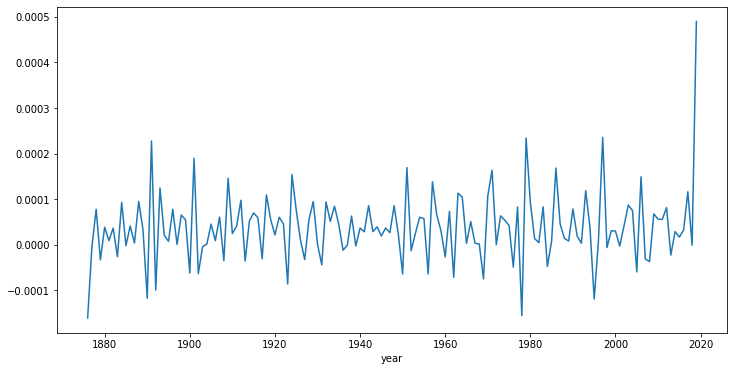

In [27]:
# Plot the data without the trend: the pct_change
y_train.groupby('year')['pct_change'].mean().plot()

# Step 4 - De-seasonalize the series

In [28]:
# 1. Create monthly means of the pct_change
y_train['monthly_means'] = y_train.groupby('month')['pct_change'].transform('mean')

# 2. Calculate the difference of the percentage change minus the monthly means of changes
y_train['deseasonalized'] = y_train['pct_change'] - y_train['monthly_means']


In [29]:
y_train.head(5)

,temp,q_tg,day,month,year,pct_change,monthly_means,deseasonalized
datetime,,,,,,,,
1876-07-01,289.85,0,1,7,1876,NaN,0.000165,NaN
1876-07-02,290.65,0,2,7,1876,0.002760,0.000165,0.002595
1876-07-03,291.15,0,3,7,1876,0.001720,0.000165,0.001555
1876-07-04,292.25,0,4,7,1876,0.003778,0.000165,0.003613
1876-07-05,293.45,0,5,7,1876,0.004106,0.000165,0.003941


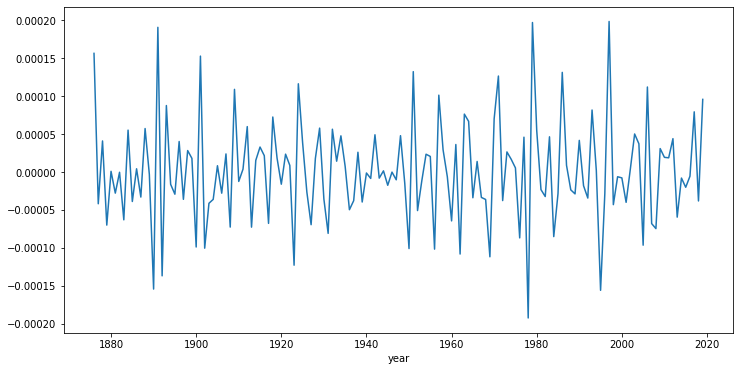

In [30]:
# Plot the deseasonalized data
y_train.groupby('year').mean()['deseasonalized'].plot()

# Step 5 - Try forecast models

### Reconstruct now the predictions on the test data

In [31]:
# add the overall mean of temperature as a starting point
y_test['y_pred_mean'] = y_train['temp'].mean()

# add the mean of the change in percentage to it
y_test['y_pred_mean_pct_change'] = y_train['pct_change'].mean()

# add the daily means of percentage chance over the whole time period to it
y_test['y_pred_monthly_mean_pct'] = y_train['monthly_means'][:366].values


y_test.head()

,temp,q_tg,day,month,year,y_pred_mean,y_pred_mean_pct_change,y_pred_monthly_mean_pct
datetime,,,,,,,,
2019-07-01,295.55,0,1,7,2019,282.550298,0.000037,0.000165
2019-07-02,290.85,0,2,7,2019,282.550298,0.000037,0.000165
2019-07-03,288.55,0,3,7,2019,282.550298,0.000037,0.000165
2019-07-04,290.05,0,4,7,2019,282.550298,0.000037,0.000165
2019-07-05,291.35,0,5,7,2019,282.550298,0.000037,0.000165


In [32]:
# y_pred_monthly_mean_pct final calculations
y_test['y_pred_monthly_mean_pct'] += 1
y_test['y_pred_monthly_mean_pct'] = np.cumprod(y_test['y_pred_monthly_mean_pct'])

# last observation:
last_observation = y_train['temp'][-1]
y_test['y_pred_monthly_mean_pct'] *= last_observation

In [33]:
y_test

,temp,q_tg,day,month,year,y_pred_mean,y_pred_mean_pct_change,y_pred_monthly_mean_pct
datetime,,,,,,,,
2019-07-01,295.55,0,1,7,2019,282.550298,0.000037,302.099944
2019-07-02,290.85,0,2,7,2019,282.550298,0.000037,302.149895
2019-07-03,288.55,0,3,7,2019,282.550298,0.000037,302.199855
2019-07-04,290.05,0,4,7,2019,282.550298,0.000037,302.249824
2019-07-05,291.35,0,5,7,2019,282.550298,0.000037,302.299800
...,...,...,...,...,...,...,...,...
2020-06-26,296.05,0,26,6,2020,282.550298,0.000037,305.912758
2020-06-27,297.95,0,27,6,2020,282.550298,0.000037,305.992680
2020-06-28,294.95,0,28,6,2020,282.550298,0.000037,306.072622


In [34]:
# Define a function that plots the forecast for us

def plot_forecast(y_train, y_test, columns):
    '''
    Plots forecasts of passenger data
    
    Params:
    -------
    y_train: The training data
    y_test: The test data
    columns: Name of the prediction columns form a DataFrame
    
    '''
    # Plot the actual values
    y_train.temp.plot(label='Training Data')
    y_test.temp.plot(label=('Test Data'))
    
    # Plot each prediction
    for column in columns:
        y_test[column].plot(label=column)
    
    # General settings
    plt.title('Monthly average temperature over Time', fontsize=15)
    plt.ylabel('Temperature in Kelvin', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend()
    # plt.savefig('mean_baseline.png')
    plt.show()

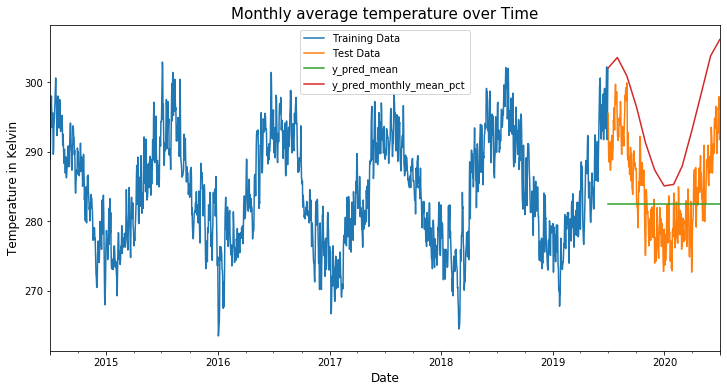

In [35]:
# For better visualization select past 5 years

past5y = y_train[-1825:]

# Plot the forecast
plot_forecast(past5y, y_test, ['y_pred_mean', 'y_pred_monthly_mean_pct'])

# Persistence Forecast

In [36]:
y_test['temp'].shift()

datetime
2019-07-01       NaN
2019-07-02    295.55
2019-07-03    290.85
2019-07-04    288.55
2019-07-05    290.05
               ...  
2020-06-26    296.35
2020-06-27    296.05
2020-06-28    297.95
2020-06-29    294.95
2020-06-30    291.75
Name: temp, Length: 366, dtype: float64

In [37]:
# Always predict the last observed value
y_test['y_pred_persistence'] = y_test['temp'].shift()
y_test.head()

,temp,q_tg,day,month,year,y_pred_mean,y_pred_mean_pct_change,y_pred_monthly_mean_pct,y_pred_persistence
datetime,,,,,,,,,
2019-07-01,295.55,0,1,7,2019,282.550298,0.000037,302.099944,NaN
2019-07-02,290.85,0,2,7,2019,282.550298,0.000037,302.149895,295.55
2019-07-03,288.55,0,3,7,2019,282.550298,0.000037,302.199855,290.85
2019-07-04,290.05,0,4,7,2019,282.550298,0.000037,302.249824,288.55
2019-07-05,291.35,0,5,7,2019,282.550298,0.000037,302.299800,290.05


In [38]:
y_test.loc['2019-07-01', 'y_pred_persistence'] = last_observation
y_test.head()

,temp,q_tg,day,month,year,y_pred_mean,y_pred_mean_pct_change,y_pred_monthly_mean_pct,y_pred_persistence
datetime,,,,,,,,,
2019-07-01,295.55,0,1,7,2019,282.550298,0.000037,302.099944,302.05
2019-07-02,290.85,0,2,7,2019,282.550298,0.000037,302.149895,295.55
2019-07-03,288.55,0,3,7,2019,282.550298,0.000037,302.199855,290.85
2019-07-04,290.05,0,4,7,2019,282.550298,0.000037,302.249824,288.55
2019-07-05,291.35,0,5,7,2019,282.550298,0.000037,302.299800,290.05


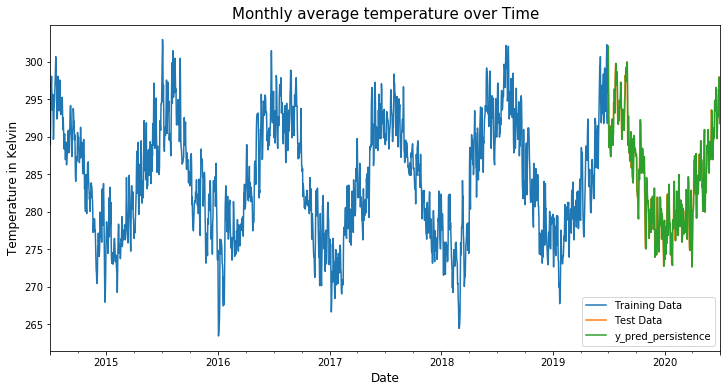

In [39]:
# Plot the prediction
plot_forecast(past5y, y_test, ['y_pred_persistence'])

## Linear Autoregressive Model


What is X and y?:


* X - past numbers of passengers
* y - future number of passengers

In [40]:
#del y_train['pct_change']
#del y_train['monthly_means']
#del y_train['deseasonalized']

y_train.head()

,temp,q_tg,day,month,year,pct_change,monthly_means,deseasonalized
datetime,,,,,,,,
1876-07-01,289.85,0,1,7,1876,NaN,0.000165,NaN
1876-07-02,290.65,0,2,7,1876,0.002760,0.000165,0.002595
1876-07-03,291.15,0,3,7,1876,0.001720,0.000165,0.001555
1876-07-04,292.25,0,4,7,1876,0.003778,0.000165,0.003613
1876-07-05,293.45,0,5,7,1876,0.004106,0.000165,0.003941


In [41]:
y_train['t-1'] = y_train['temp'].shift(1)
y_train['t-2'] = y_train['temp'].shift(2)
y_train['t-3'] = y_train['temp'].shift(3)

In [42]:
y_train = y_train.dropna()

In [43]:
y_train.head()

,temp,q_tg,day,month,year,pct_change,monthly_means,deseasonalized,t-1,t-2,t-3
datetime,,,,,,,,,,,
1876-07-04,292.25,0,4,7,1876,0.003778,0.000165,0.003613,291.15,290.65,289.85
1876-07-05,293.45,0,5,7,1876,0.004106,0.000165,0.003941,292.25,291.15,290.65
1876-07-06,294.35,0,6,7,1876,0.003067,0.000165,0.002902,293.45,292.25,291.15
1876-07-07,296.35,0,7,7,1876,0.006795,0.000165,0.006629,294.35,293.45,292.25
1876-07-08,296.85,0,8,7,1876,0.001687,0.000165,0.001522,296.35,294.35,293.45


In [44]:
X = y_train[['t-1', 't-2', 't-3']]
y = y_train['temp']

In [45]:
m = LinearRegression()
m.fit(X, y)
m.score(X, y)   # R^2

0.9109611032737122

In [46]:
m.coef_, m.intercept_

(array([ 1.00531922, -0.20735344,  0.16087697]), 11.629173074155233)

In [47]:
y_train['y_pred_ar'] = m.predict(X)

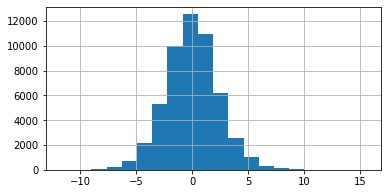

In [48]:
(y_train['y_pred_ar'] - y_train['temp']).hist(bins=20, figsize=(6,3))

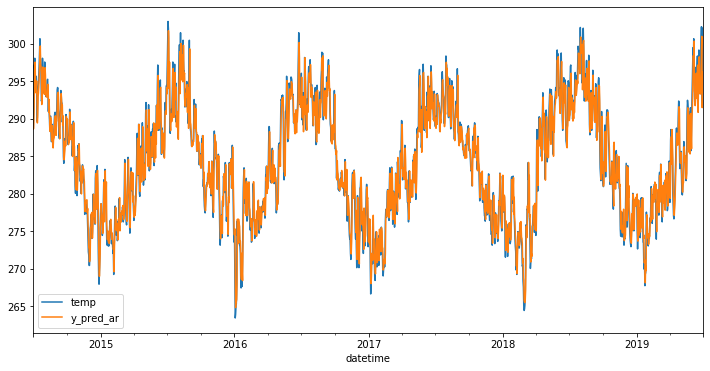

In [49]:
past5y = y_train[-1825:]
past5y[['temp', 'y_pred_ar']].plot()

In [50]:
y_train

,temp,q_tg,day,month,year,pct_change,monthly_means,deseasonalized,t-1,t-2,t-3,y_pred_ar
datetime,,,,,,,,,,,,
1876-07-04,292.25,0,4,7,1876,0.003778,0.000165,0.003613,291.15,290.65,289.85,290.690779
1876-07-05,293.45,0,5,7,1876,0.004106,0.000165,0.003941,292.25,291.15,290.65,291.821655
1876-07-06,294.35,0,6,7,1876,0.003067,0.000165,0.002902,293.45,292.25,291.15,292.880387
1876-07-07,296.35,0,7,7,1876,0.006795,0.000165,0.006629,294.35,293.45,292.25,293.713315
1876-07-08,296.85,0,8,7,1876,0.001687,0.000165,0.001522,296.35,294.35,293.45,295.730388
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26,302.25,0,26,6,2019,0.006661,0.000261,0.006400,300.25,296.75,294.35,299.298274
2019-06-27,292.65,0,27,6,2019,-0.031762,0.000261,-0.032023,302.25,300.25,296.75,300.969280
2019-06-28,291.75,0,28,6,2019,-0.003075,0.000261,-0.003337,292.65,302.25,300.25,291.466578


# Compare their mean absolute errors

In [51]:
y_test = y_test.drop(['y_pred_mean_pct_change'], 1)
y_test['y_pred_ar'] = y_train['y_pred_ar'][:366].values

y_test.tail()

,temp,q_tg,day,month,year,y_pred_mean,y_pred_monthly_mean_pct,y_pred_persistence,y_pred_ar
datetime,,,,,,,,,
2020-06-26,296.05,0,26,6,2020,282.550298,305.912758,296.35,290.549557
2020-06-27,297.95,0,27,6,2020,282.550298,305.992680,296.05,294.547173
2020-06-28,294.95,0,28,6,2020,282.550298,306.072622,297.95,294.833189
2020-06-29,291.75,0,29,6,2020,282.550298,306.152585,294.95,293.524120
2020-06-30,292.35,0,30,6,2020,282.550298,306.203207,291.75,291.544935


In [52]:
predictions = y_test.columns[5:]

In [81]:
for prediction in predictions:
    print(f'The mean absolute error of {prediction} is:')
    print(f'{mean_absolute_error(y_test["temp"], y_test[prediction]).round(1)}')
    print()

The mean absolute error of y_pred_mean is:
5.8

The mean absolute error of y_pred_monthly_mean_pct is:
10.1

The mean absolute error of y_pred_persistence is:
1.8

The mean absolute error of y_pred_ar is:
4.2



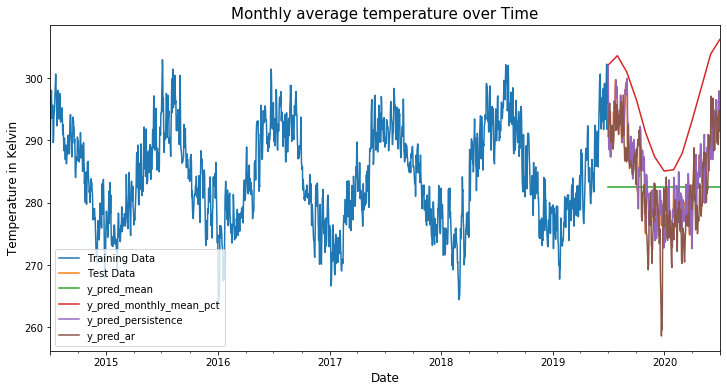

In [54]:
plot_forecast(past5y, y_test, predictions)

The Persistence forecast seems to be the best fitting model and it is the one with the lowest MAE, followed by the Linear Autoregressive model.

# Test FB Prophet

<img src=https://i.pinimg.com/564x/ff/89/de/ff89de3868214e90fbe0689218222b12.jpg width="250" align="left">

#### Prerequisite:
- FB Prophet is a univariate, time series model.
- in order for it to work, you must have a pandas DataFrame with 2 columns:
    - 1st column must be of the Pandas DateTime type and must be called ``ds``
    - 2nd column must be some numerical variable you're trying to forecast, and must be called ``y``

In [55]:
data = y_train.reset_index()

In [56]:
data = data[['datetime', 'temp']]

In [57]:
data = data.rename(columns={'datetime':'ds', 'temp':'y'})

In [58]:
data.head()

,ds,y
0,1876-07-04,292.25
1,1876-07-05,293.45
2,1876-07-06,294.35
3,1876-07-07,296.35
4,1876-07-08,296.85


#### Import model

In [59]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [60]:
m = Prophet(weekly_seasonality=True, daily_seasonality=True)

#### Train model

*Similar to a generalized additive model (GAM), with time as a regressor, Prophet fits several linear and non-linear functions of time as components. In its simplest form:*

``y(t) = g(t) + s(t) + h(t) + e(t)``

*where:*

- ``g(t)`` -> trend models non-periodic changes (i.e. growth over time)

    - You can also program in "saturated growth", e.g. try setting ``growth='logistic'``
    
- ``s(t)`` -> seasonality presents periodic changes (i.e. weekly, monthly, yearly)

    - *Prophet relies on Fourier series to provide a malleable model of periodic effects.*
    
- ``h(t)`` -> ties in effects of holidays (on potentially irregular schedules ≥ 1 day(s))

- ``e(t)`` -> covers idiosyncratic changes not accommodated by the model

*Prophet is essentially "**framing the forecasting problem as a curve-fitting exercise**" rather than looking explicitly at the time based dependence of each observation.*

In [61]:
m.fit(data)

#### Prepare "future dataframe"

In [62]:
future = m.make_future_dataframe(periods=24, freq='MS', include_history=False)
#2 years into the future

In [63]:
future.tail()

,ds
19,2021-02-01
20,2021-03-01
21,2021-04-01
22,2021-05-01
23,2021-06-01


#### Predict

In [64]:
forecast = m.predict(future)

In [65]:
forecast.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-07-01,291.310469,288.438122,297.419147,291.310469,291.310469,1.608307,1.608307,1.608307,-7.293162,...,0.060425,0.060425,0.060425,8.841044,8.841044,8.841044,0.0,0.0,0.0,292.918777
1,2019-08-01,291.313163,288.804364,298.420628,291.313163,291.313163,2.370524,2.370524,2.370524,-7.293162,...,-0.034233,-0.034233,-0.034233,9.697919,9.697919,9.697919,0.0,0.0,0.0,293.683687
2,2019-09-01,291.315857,286.591807,295.956888,291.315857,291.315857,-0.065443,-0.065443,-0.065443,-7.293162,...,0.009958,0.009958,0.009958,7.217760,7.217760,7.217760,0.0,0.0,0.0,291.250413


#### Visualization

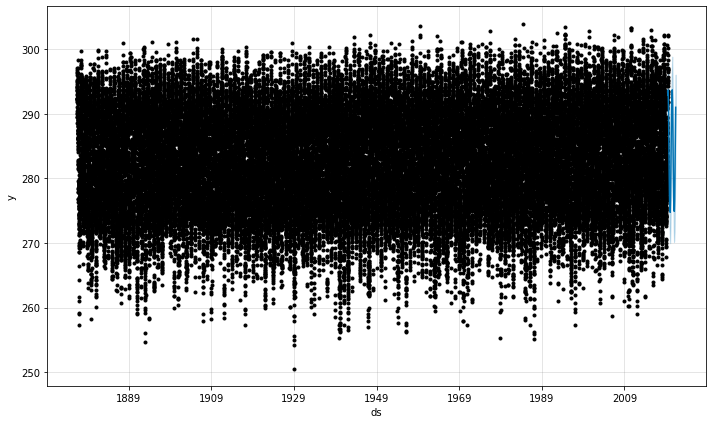

In [66]:
fig = m.plot(forecast)

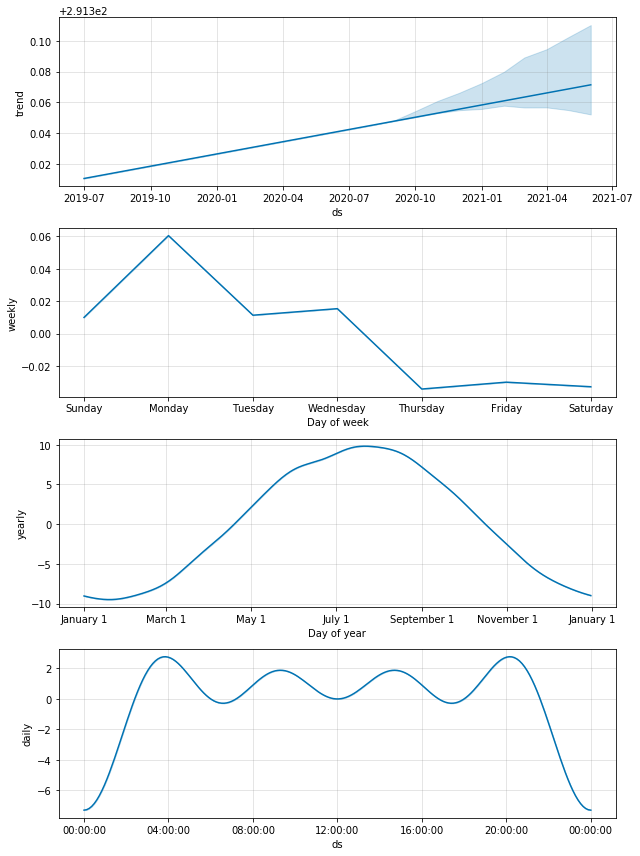

In [67]:
fig2 = m.plot_components(forecast)

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

In [68]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='3650 days', period='3650 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 14 forecasts with cutoffs between 1888-07-31 00:00:00 and 2018-06-30 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1888-08-01,290.837513,286.520709,294.931654,290.45,1888-07-31
1,1888-08-02,290.659425,286.318989,294.977840,289.75,1888-07-31
2,1888-08-03,290.681368,286.344347,295.324106,287.95,1888-07-31
3,1888-08-04,290.671743,286.093772,295.320897,287.55,1888-07-31
4,1888-08-05,290.642979,286.268106,295.295831,288.05,1888-07-31


The output of cross_validation is a dataframe with the true values y and the out-of-sample forecast values yhat, at each simulated forecast date and for each cutoff date. In particular, a forecast is made for every observed point between cutoff and cutoff + horizon. This dataframe can then be used to compute error measures of yhat vs. y.

The performance_metrics utility can be used to compute some useful statistics of the prediction performance as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), and coverage of the yhat_lower and yhat_upper estimates. These are computed on a rolling window of the predictions in the Cross Validation after sorting by horizon (ds minus cutoff). By default 10% of the predictions will be included in each window, but this can be changed with the rolling_window argument.

In [69]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [70]:
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
324,361 days,12.955018,3.599308,2.950533,0.010139,0.008666,0.815068
325,362 days,12.801352,3.577898,2.936084,0.010088,0.008579,0.815068
326,363 days,12.616326,3.551947,2.919796,0.010033,0.008548,0.816047
327,364 days,12.484971,3.533408,2.912134,0.010004,0.008517,0.818982
328,365 days,12.608157,3.550797,2.915623,0.010007,0.008517,0.818982


## test with smaller data

In [71]:
data2 = data[-3650:]
data2.head()

,ds,y
48576,2009-07-03,296.65
48577,2009-07-04,295.35
48578,2009-07-05,293.75
48579,2009-07-06,294.05
48580,2009-07-07,293.35


In [72]:
m2 = Prophet(weekly_seasonality=True, daily_seasonality=True)

In [73]:
m2.fit(data2)

In [74]:
future = m2.make_future_dataframe(periods=24, freq='MS', include_history=False)
future.tail()

,ds
19,2021-02-01
20,2021-03-01
21,2021-04-01
22,2021-05-01
23,2021-06-01


In [75]:
forecast2 = m2.predict(future)

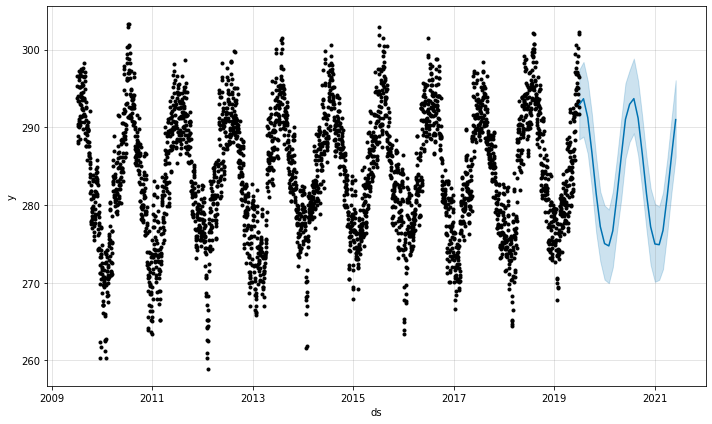

In [76]:
fig_2 = m2.plot(forecast)

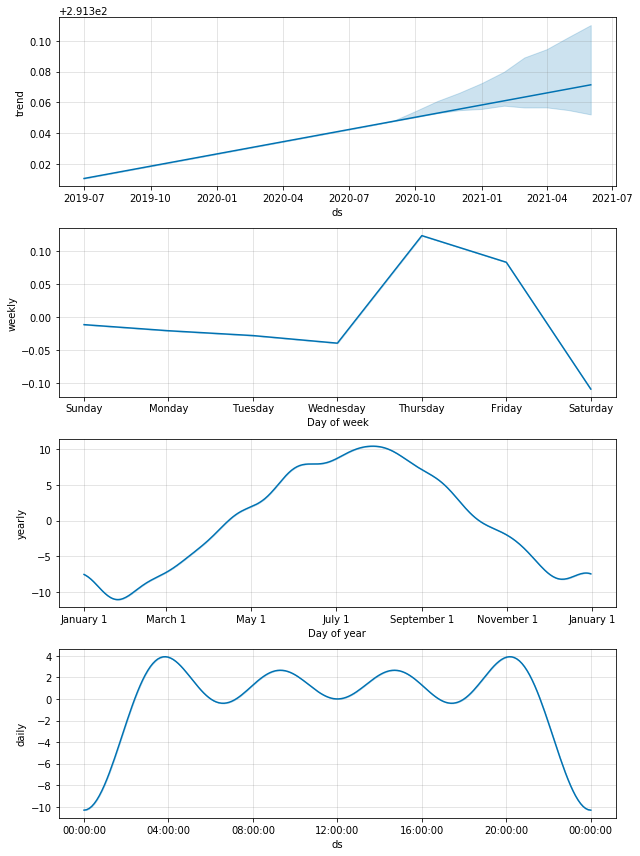

In [77]:
fig2_2 = m2.plot_components(forecast)

In [78]:
df_cv2 = cross_validation(m2, initial='730 days', period='180 days', horizon = '365 days')
df_cv2.head()

INFO:fbprophet:Making 15 forecasts with cutoffs between 2011-08-06 00:00:00 and 2018-06-30 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-08-07,290.487928,286.345215,294.674978,293.15,2011-08-06
1,2011-08-08,290.300102,285.798181,294.550642,290.05,2011-08-06
2,2011-08-09,290.311886,286.054691,294.598228,289.35,2011-08-06
3,2011-08-10,290.483085,285.920853,294.464170,288.45,2011-08-06
4,2011-08-11,290.909903,286.458805,295.456415,291.95,2011-08-06


In [79]:
df_p2 = performance_metrics(df_cv2)

In [80]:
df_p2.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
324,361 days,43.462166,6.592584,4.898764,0.017153,0.012412,0.834613
325,362 days,44.282225,6.654489,4.912834,0.017196,0.012302,0.832785
326,363 days,44.500771,6.670890,4.921531,0.017229,0.012314,0.832907
327,364 days,44.583919,6.677119,4.934863,0.017280,0.012391,0.836563
328,365 days,44.616003,6.679521,4.951617,0.017337,0.012581,0.836563


# THE END